# PRUEBA PRÁCTICA LITE THINKING: Predicción del Alquiler de Bicicletas

In [1]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae,r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn import model_selection
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import math


In [2]:
# Loading the data
df = pd.read_csv('./Bike-Sharing-Dataset/hour.csv')
df_init = df
print("Columns:",df.columns)
print("Shape:",df.shape)
df.head()

Columns: Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')
Shape: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


based on the documentation we define

In [3]:

df['holiday'][df['holiday'] == 0] = 'Not Holiday'
df['holiday'][df['holiday'] == 1] = 'Holiday'
df['weathersit'][df['weathersit'] == 1] = 'Clear'
df['weathersit'][df['weathersit'] == 2] = 'Cloudy'
df['weathersit'][df['weathersit'] == 3] = 'Light Rain'
df['weathersit'][df['weathersit'] == 4] = 'Heavy Rain'
df['yr'][df['yr'] == 0] = '2011'
df['yr'][df['yr'] == 1] = '2012'
df['season'][df['season'] == 1] = 'winter'
df['season'][df['season'] == 2] = 'spring'
df['season'][df['season'] == 3] = 'summer'
df['season'][df['season'] == 4] = 'fall'
df = df.rename(columns={'weathersit':'weather','yr':'year','mnth':'month','hr':'hour','hum':'humidity','cnt':'count'})


C:\Users\dcnav\AppData\Local\Temp\ipykernel_18512\1300697340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['holiday'][df['holiday'] == 0] = 'Not Holiday'
C:\Users\dcnav\AppData\Local\Temp\ipykernel_18512\1300697340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['holiday'][df['holiday'] == 1] = 'Holiday'
C:\Users\dcnav\AppData\Local\Temp\ipykernel_18512\1300697340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['

checking for null data


In [4]:
print("Is There null data? =  ",df.isnull().sum().any())

Is There null data? =   False


# EDA

<AxesSubplot:xlabel='season', ylabel='count'>

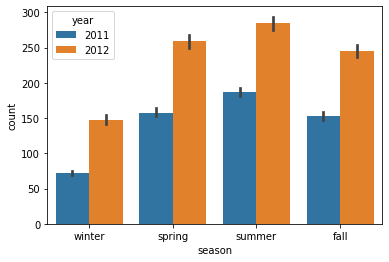

In [5]:
sns.barplot(x="season",y="count",data=df,hue="year")


<AxesSubplot:xlabel='hour'>

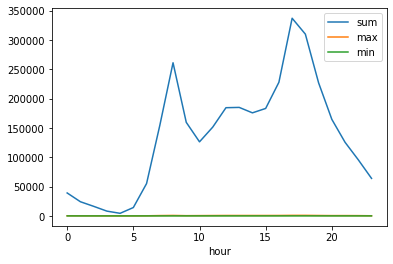

In [6]:
df_hour = df.groupby(["hour"])["count"].agg(["sum","max","min"])
df_hour.plot()

<AxesSubplot:xlabel='month', ylabel='count'>

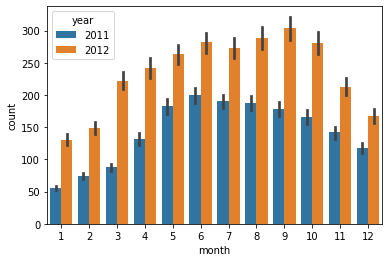

In [7]:
sns.barplot(x="month",y="count",data=df,hue="year")


Text(0, 0.5, 'number of rides per day')

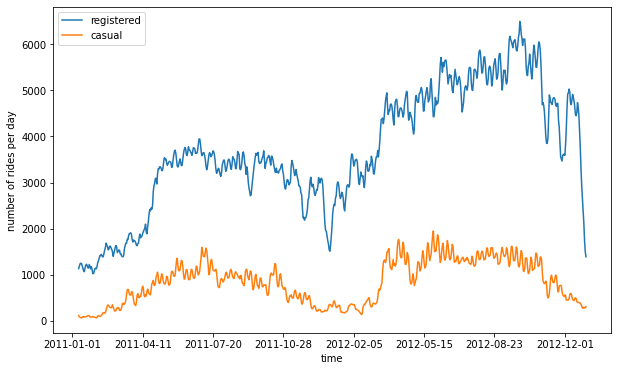

In [8]:
"""
Create new dataframe with necessary for plotting columns, and obtain
number of rides per day, by grouping over each day
"""
plot_data = df[['registered', 'casual', 'dteday']]
plot_data = plot_data.groupby('dteday').sum()
"""
define window for computing the rolling mean and standard deviation
"""
window = 10
rolling_means = plot_data.rolling(window).mean()
rolling_deviations = plot_data.rolling(window).std()

ax = rolling_means.plot(figsize=(10,6))
ax.set_xlabel("time")
ax.set_ylabel("number of rides per day")

In [9]:
df.groupby(["year","holiday"])["count"].agg(["sum"])

sum
year holiday             
2011 Holiday        30022
     Not Holiday  1213081
2012 Holiday        48413
     Not Holiday  2001163

<AxesSubplot:xlabel='weather', ylabel='count'>

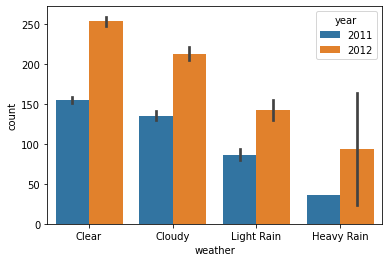

In [10]:
sns.barplot(x="weather",y="count",data=df,hue="year")


[620017, 2672662]


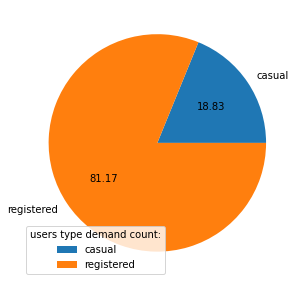

In [11]:
plt.figure(figsize=(5,5))
c_t=df["casual"].sum()
r_t=df["registered"].sum()
l=[c_t,r_t]
print(l)
mylabels = ["casual", "registered"]
plt.pie(l,labels = mylabels,autopct ='%.2f')
plt.legend(title = "users type demand count:")
plt.show()

[Text(0.5, 1.0, 'Relation between humidity and users')]

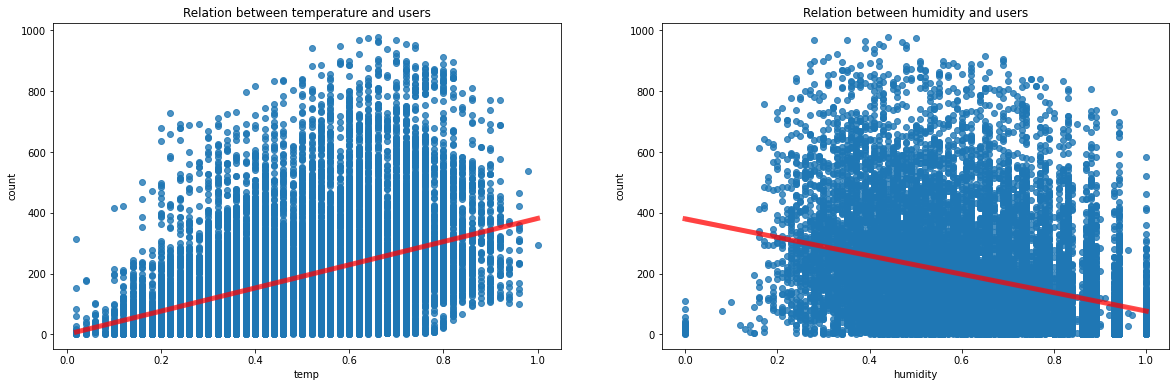

In [12]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,6))
sns.regplot(x=df['temp'], y=df['count'], ax=ax1,line_kws={"color":"r","alpha":0.7,"lw":5})
ax1.set(title="Relation between temperature and users")
sns.regplot(x=df['humidity'], y=df['count'], ax=ax2,line_kws={"color":"r","alpha":0.7,"lw":5})
ax2.set(title="Relation between humidity and users")

<AxesSubplot:>

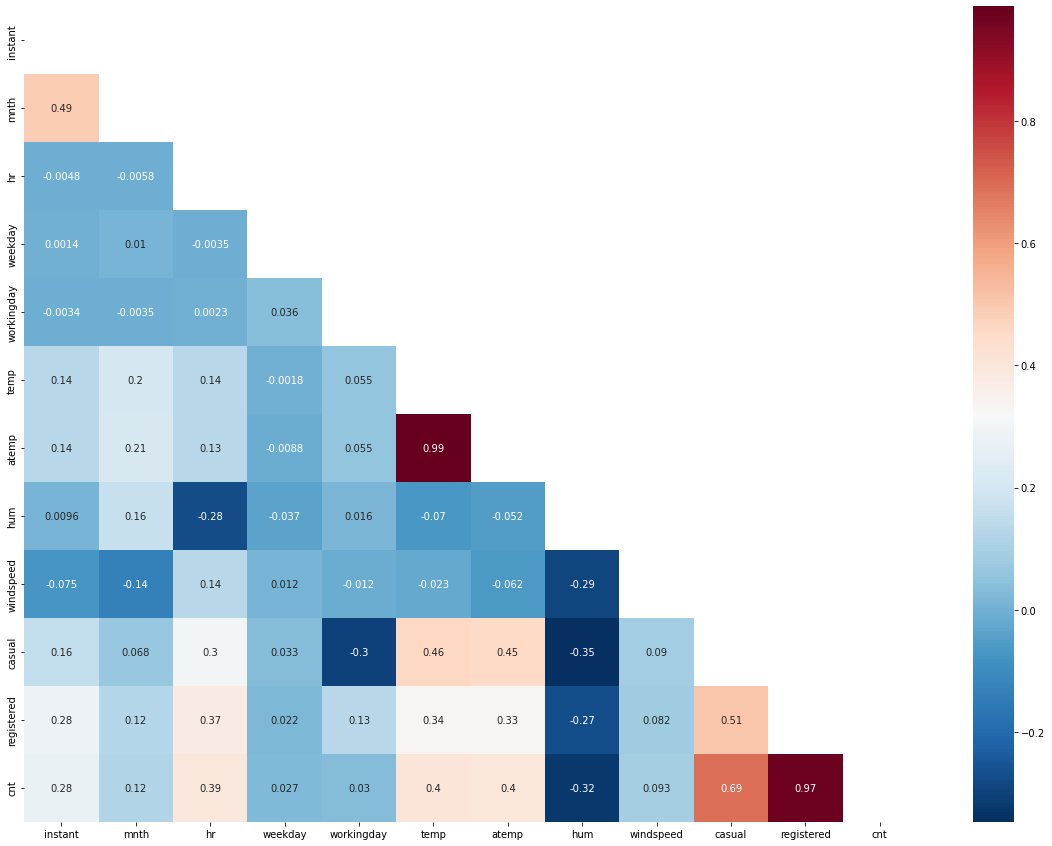

In [13]:
plt.figure(figsize=(20,15))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_init.corr(),cmap='RdBu_r',mask=mask, annot=True)

In [14]:
df.corr()["count"]

instant       0.278379
month         0.120638
hour          0.394071
weekday       0.026900
workingday    0.030284
temp          0.404772
atemp         0.400929
humidity     -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
count         1.000000
Name: count, dtype: float64

In [15]:
df = df.drop(columns=['instant', 'dteday', 'year'])
df_oh = df
def one_hot_encoding(data, column):
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column, drop_first=True)], axis=1)
    data = data.drop([column], axis=1)
    return data
cols = ['season','month','hour','holiday','weekday','workingday','weather']
for col in cols:
    df_oh = one_hot_encoding(df_oh, col)

df_oh.head()

,temp,atemp,humidity,windspeed,casual,registered,count,season_spring,season_summer,season_winter,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weather_Cloudy,weather_Heavy Rain,weather_Light Rain
0,0.24,0.2879,0.81,0.0,3,13,16,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.22,0.2727,0.80,0.0,8,32,40,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.22,0.2727,0.80,0.0,5,27,32,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0.24,0.2879,0.75,0.0,3,10,13,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0.24,0.2879,0.75,0.0,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [16]:
x = df_oh.drop(columns=[ 'count'], axis=1)
y = df_oh['count']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state= 42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(13903, 54)
(13903,)
(3476, 54)
(3476,)


Recursive Feature Elimination : To check what are the features really relevants

In [17]:
lr = LinearRegression()
lr.fit(x_train, y_train)
rfe = RFE(lr,n_features_to_select=20)
rfe.fit(x_train,y_train)
list(zip(x_train.columns, rfe.support_, rfe.ranking_))
print("Supportable columns - ",x_train.columns[rfe.support_].tolist())

print("Unsupportable columns - ",x_train.columns[~rfe.support_].tolist())

Supportable columns -  ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month_4', 'month_6', 'month_8', 'month_9', 'month_10', 'month_12', 'hour_5', 'hour_6', 'hour_16', 'weekday_4', 'workingday_1', 'weather_Cloudy', 'weather_Heavy Rain', 'weather_Light Rain']
Unsupportable columns -  ['season_spring', 'season_summer', 'season_winter', 'month_2', 'month_3', 'month_5', 'month_7', 'month_11', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'holiday_Not Holiday', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_5', 'weekday_6']


In [18]:
col =x.columns[rfe.support_]

x = x[col]

In [19]:

models = [LinearRegression(),KNeighborsClassifier(),DecisionTreeRegressor(),RandomForestRegressor(),GradientBoostingRegressor()]

def train(model):
    kfold = model_selection.KFold(n_splits=5)
    pred = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='neg_mean_squared_error')
    cv_score = pred.mean()
    print('Model:',model)
    print('CV score:', abs(cv_score))
for model in models:
    train(model)

Model: LinearRegression()
CV score: 3.1460403888055965e-26
Model: KNeighborsClassifier()
CV score: 45.472393009412954
Model: DecisionTreeRegressor()
CV score: 45.171206762093206
Model: RandomForestRegressor()
CV score: 24.134685105544285
Model: GradientBoostingRegressor()
CV score: 37.38452323652999


 Mean squarred Error:  7.096152128883773
 mean absolute error:  0.9175143843498273
 root mean squarred error:  2.6638603808915686
 R square:  0.9997759021017133


Text(0, 0.5, 'y_pred')

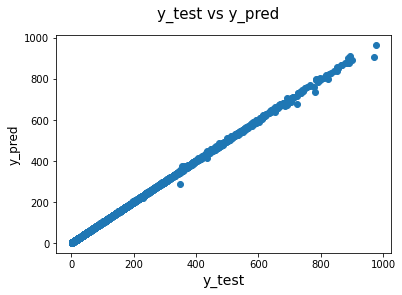

In [20]:
model_rf = RandomForestRegressor()
model_rf.fit(x_train, y_train)

y_pred = model_rf.predict(x_test)
mean_sq_err = mse(y_test,y_pred)
print(" Mean squarred Error: ",mean_sq_err)

mae_result= mae(y_test,y_pred)
print(" mean absolute error: ",mae_result)

rmse = math.sqrt(mean_sq_err)
print(" root mean squarred error: ",rmse)
r2_score_result= r2_score(y_test,y_pred)
print(" R square: ",r2_score_result)
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 15)             
plt.xlabel('y_test', fontsize = 14)                          
plt.ylabel('y_pred', fontsize = 12) 


 Mean squarred Error:  2.1304589339549045e-25
 mean absolute error:  3.305321749584833e-13
 root mean squarred error:  4.61568947607495e-13
 R square:  1.0


Text(0, 0.5, 'y_pred')

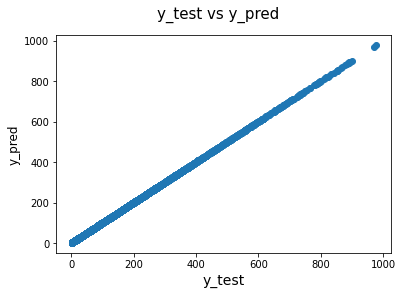

In [21]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)

y_pred = model_lr.predict(x_test)
mean_sq_err = mse(y_test,y_pred)
print(" Mean squarred Error: ",mean_sq_err)

mae_result= mae(y_test,y_pred)
print(" mean absolute error: ",mae_result)

rmse = math.sqrt(mean_sq_err)
print(" root mean squarred error: ",rmse)
r2_score_result= r2_score(y_test,y_pred)
print(" R square: ",r2_score_result)
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 15)             
plt.xlabel('y_test', fontsize = 14)                          
plt.ylabel('y_pred', fontsize = 12) 

In [25]:
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam

from keras.models import Sequential
from keras.layers import Dense, Dropout

features = x_train.shape[1]
print(features)
model = Sequential()
model.add(Dense(512, input_shape=(features,), activation='relu'))
model.add(Dense(512))
model.add(Dense(64))
model.add(Dense(1, activation='linear'))

model.summary()


54
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               28160     
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 323,713
Trainable params: 323,713
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer="adam", loss="mean_squared_error")
results = model.fit(x_train, y_train, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
435/435 [==============================] - 3s 5ms/step - loss: 11.7194 - val_loss: 15.0593
Epoch 2/10
435/435 [==============================] - 2s 5ms/step - loss: 2.3127 - val_loss: 0.0252
Epoch 3/10
435/435 [==============================] - 2s 5ms/step - loss: 24.4215 - val_loss: 0.2203
Epoch 4/10
435/435 [==============================] - 2s 5ms/step - loss: 5.6856 - val_loss: 0.0262
Epoch 5/10
435/435 [==============================] - 2s 5ms/step - loss: 0.1360 - val_loss: 0.0969
Epoch 6/10
435/435 [==============================] - 2s 4ms/step - loss: 1.7840 - val_loss: 0.8319
Epoch 7/10
435/435 [==============================] - 2s 4ms/step - loss: 41.2172 - val_loss: 4.5286
Epoch 8/10
435/435 [==============================] - 2s 4ms/step - loss: 0.3232 - val_loss: 0.0133
Epoch 9/10
435/435 [==============================] - 2s 5ms/step - loss: 0.0062 - val_loss: 0.0081
Epoch 10/10
435/435 [==============================] - 2s 5ms/step - loss: 0.0378 - val_loss: 0.

In [29]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

109/109 [==============================] - 0s 4ms/step - loss: 0.0269
test loss, test acc: 0.0269396360963583


109/109 [==============================] - 1s 3ms/step
 Mean squarred Error:  0.026939731076088623
 mean absolute error:  0.11328574396043982
 root mean squarred error:  0.1641332723005565
 R square:  0.9999991492379243


Text(0, 0.5, 'y_pred')

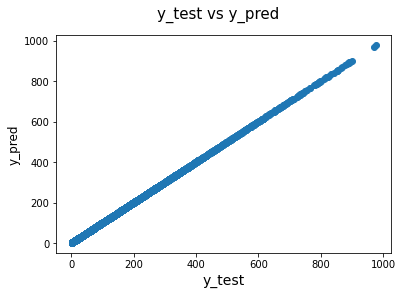

In [30]:
y_pred = model.predict(x_test)
mean_sq_err = mse(y_test,y_pred)
print(" Mean squarred Error: ",mean_sq_err)

mae_result= mae(y_test,y_pred)
print(" mean absolute error: ",mae_result)

rmse = math.sqrt(mean_sq_err)
print(" root mean squarred error: ",rmse)
r2_score_result= r2_score(y_test,y_pred)
print(" R square: ",r2_score_result)
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 15)             
plt.xlabel('y_test', fontsize = 14)                          
plt.ylabel('y_pred', fontsize = 12) 